# 1. Data preparation and understanding

### 1.1. Importing all the important libraries

In [1]:
# Import the required libraries
import numpy as np
import pandas as pd

import os
import pathlib
import PIL
import random
import shutil
from glob import glob

import Augmentor

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling, Input, BatchNormalization, Lambda, RandomFlip
from keras.losses import CategoricalCrossentropy
from keras.optimizers import adam_v2 as Adam
from keras.callbacks import LearningRateScheduler

The dataset contains 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('C:/development/data/ISIC/Train')
data_dir_test = pathlib.Path('C:/development/data/ISIC/Test')

In [4]:
# Count the number of images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Training images:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:", image_count_test)

Training images: 2239
Test images: 118


### 1.2. Configure the dataset loader

Define some parameters for the loader:

In [5]:
# Define the image parameters to be used in the tensor
batch_size = 32
img_height = 180
img_width = 180

Define the train and test datasets for importation. Use 80% of the images for training, and 20% for validation.

In [6]:
# Define the train and validation datasets for importation
# Resize the images using a Lanczos filter
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    validation_split=0.2,
    subset='both',
    seed=123,
    color_mode='rgb',
    interpolation='lanczos3',
    shuffle=True,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [7]:
# Define the test datasets for importation
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_test,
    color_mode='rgb',
    interpolation='lanczos3',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [8]:
# List out all the classes of skin cancer and store them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
# Configure the loader
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### 1.3. Visualize the dataset

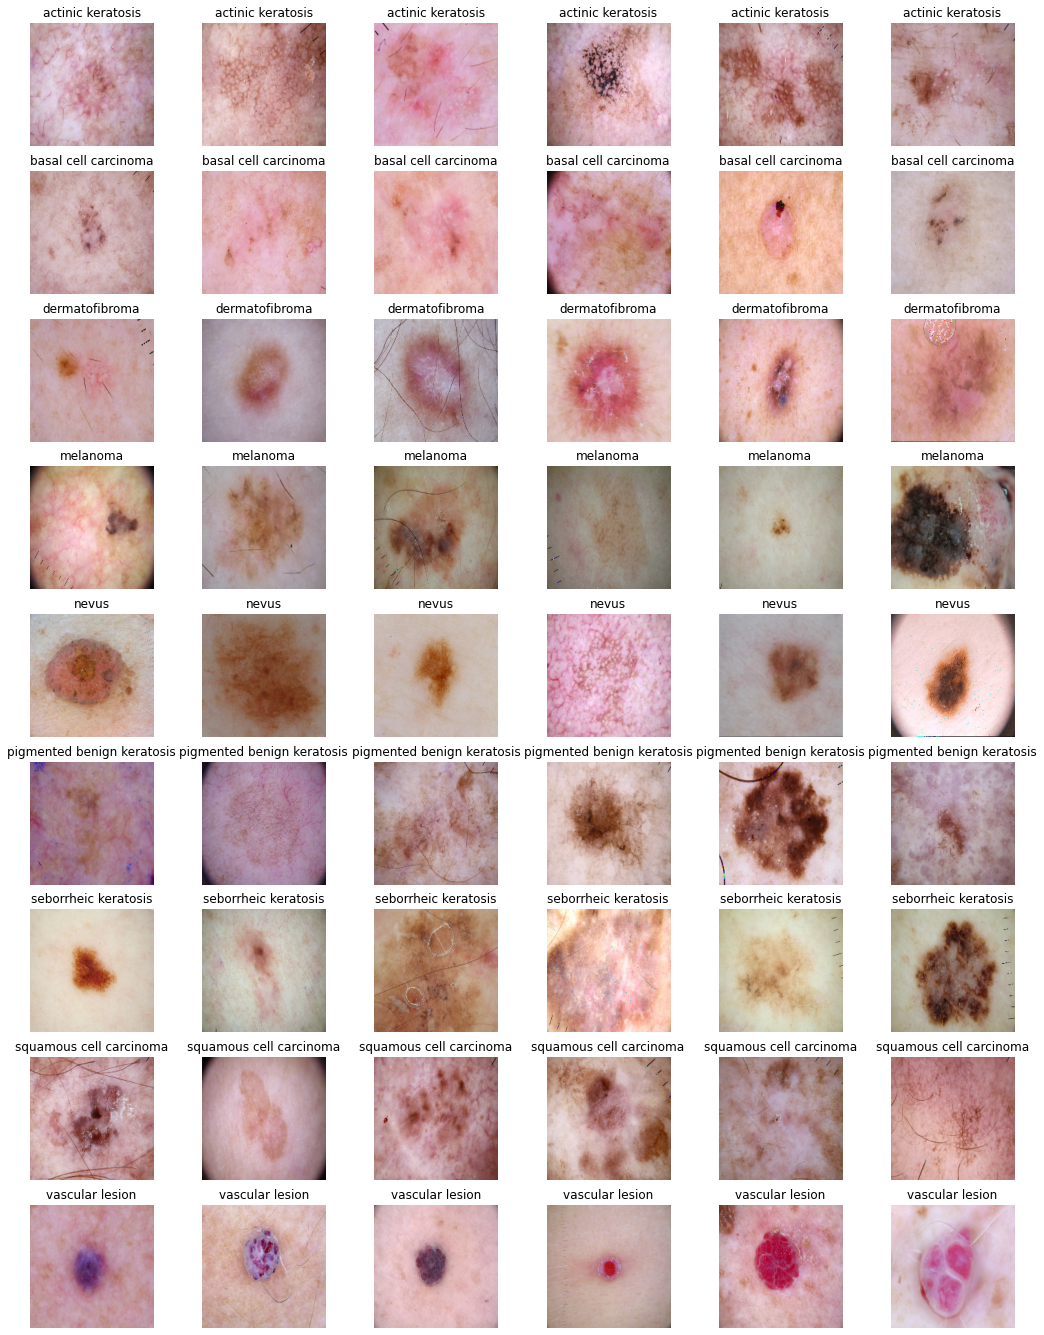

In [10]:
# Define the number of images of each class to plot
images_per_class = 6

# Create a dictionary as the placeholder for the images
image_dict = {}
for class_name in class_names:
    image_dict[class_name] = []

# Copy some images from the tensor into the dictionary
for (image, label) in tuple(train_ds.unbatch()):
    image_class = class_names[label.numpy().nonzero()[0][0]]
    if len(image_dict[image_class]) < images_per_class:
        image_dict[image_class].append(image)

# Plot the images
fig = plt.figure(figsize=(18, 24))
i = 1;
for image_class in image_dict.keys():
    images_in_class = image_dict[image_class]
    for image in images_in_class:
        ax = plt.subplot(len(class_names), images_per_class, i)
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(image_class)
        plt.axis("off")
        i += 1;

# 2. Sequential network with no data augmentation

### 2.1. Create the model

Create a model with four sequential blocks that use two convolutional layers each. Use a ReLU activation function on each convolutional layer, and complete each block with max pooling, batch normalization, and dropout layers.

In [33]:
# Instantiate a sequential model
model = Sequential()

# Add an input layer
model.add(Input(shape=(img_height, img_width, 3), name="image"))

# Add an rescaling layer to convert the pixel value ranges from 0-255 to 0-1
model.add(Rescaling(1.0/255.0, input_shape=(img_height, img_width, 3)))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with a flattening layer using ReLU activation
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(9))
model.add(Activation('softmax'))

In [34]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 activation_24 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 activation_25 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                      

### 2.2. Visualize the model

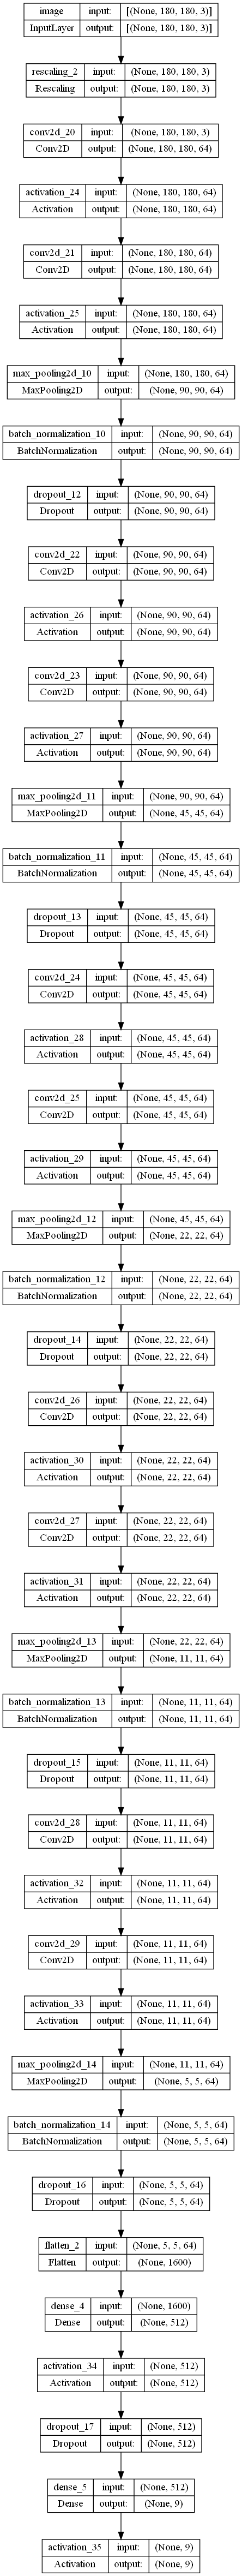

In [35]:
# Create and plot a diagram of the model
keras.utils.plot_model(model, "sequential_network.png", show_shapes=True)

### 2.3. Compile the model

Use categorical crossentropy for the loss function and the Adam algorithm for optimization. The Adam algorithm is an extension to stochastic gradient descent.

In [38]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 2.4. Configurate a variable learning rate

We can reduce the learning rate over time by adding a custom callback to the model.

In [14]:
# Create a callback to reduce the learning rate
def lr_scheduler(epoch, lr):
    # Reduce the learing rate by half every 10 epochs between 20 epochs and 50
    if epoch % 10 == 0 and epoch >= 20 and epoch <=50:
        lr = lr * 0.5
    return lr

callbacks = [LearningRateScheduler(lr_scheduler, verbose=0)]

In [39]:
# Create a callback to reduce the learning rate
def lr_scheduler(epoch, lr):
    if epoch < 20:
        lr = 0.001
    elif epoch < 35:
        lr = 0.00033
    else:
        lr = 0.0001
    return lr

callbacks = [LearningRateScheduler(lr_scheduler, verbose=0)]

### 2.5. Train the model

In [40]:
# Train the model for 50 epochs with a learning rate that reduces over time
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/50
56/56 [==============================] - 16s 250ms/step - loss: 2.9819 - accuracy: 0.2327 - val_loss: 2.4042 - val_accuracy: 0.0872 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 14s 248ms/step - loss: 2.3314 - accuracy: 0.2974 - val_loss: 2.4845 - val_accuracy: 0.1611 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 14s 248ms/step - loss: 2.0102 - accuracy: 0.3594 - val_loss: 2.7689 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - 14s 245ms/step - loss: 1.7434 - accuracy: 0.4001 - val_loss: 2.3479 - val_accuracy: 0.1544 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 14s 250ms/step - loss: 1.6160 - accuracy: 0.4353 - val_loss: 1.9172 - val_accuracy: 0.2953 - lr: 0.0010
Epoch 6/50
56/56 [==============================] - 14s 245ms/step - loss: 1.4871 - accuracy: 0.4799 - val_loss: 2.2694 - val_accuracy: 0.2170 - lr: 0.0010
Epoch 7/50
56/56 [==============================] - 14s 247ms/st

### 2.6. Visualize the training results

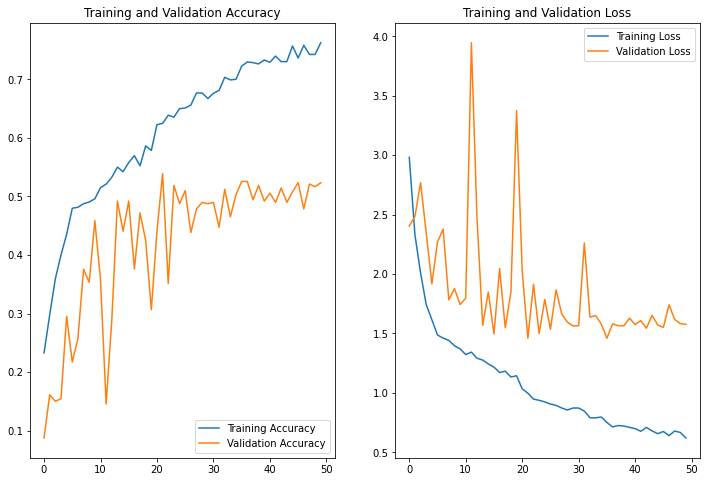

In [41]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2.7. Verify predictions against the test dataset

In [42]:
# Make predictions against the test dataset and compute the model accuracy
test_predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
  test_predictions = np.concatenate([test_predictions, np.argmax(model.predict(x), axis = -1)])
  test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

test_accuracy = np.sum(test_predictions == test_labels) / len(test_predictions)
print('Test accuracy:', test_accuracy)

1/1 [==============================] - 0s 193ms/step
Test accuracy: 0.3220338983050847


### 2.8. Discussion and findings

This relatively simple model achieves roughly 50% accuracy against the validation dataset. But verification against the relatively small test dataset yielded only 32% accuracy.

The model appears to be overfitting the training data. This can be seen with the validation accuracy tapering off after around 25 epochs of training while the training accuracy continues to improve after that.

The relatively small training dataset may be contributing to the overfitting of the model. The class imbalance of the training data is likely hampering effective training of the model. Overrepresented classes will have proportionately larger weights in the model, making predictions inaccurate.

# 3. Sequential network with data augmentation layers

Variability can be introduced into the training data by randomly rotating and flipping the training images. This should reduce the tendency of the model to overfit.

By adding the augmentation layers inside the network one can take advantage of GPU computation. However, because the images have already been resized during loading, fine rotations or scaling cannot be applied without degrading the image quality. This approach is therefore restricted to rotating the images in multiples of 90 degrees and flipping them vertically and horizontally.

### 3.1. Create a custom model layer to rotate the images

To avoid data loss and clipping by fine rotations, we want to rotate the image by multiples of 90 degress.

In [43]:
# Define a function to randomly rotate the image by multiples of 90 degress
def random_rotation(x):
    rotations = random.randint(0, 3)
    return tf.image.rot90(x, k=rotations)

### 3.2. Create the model

Utilize the same model as was used previously, but add preprocessing layers to augment the data.

In [44]:
# Instantiate a sequential model
model = Sequential()

# Add an input layer
model.add(Input(shape=(img_height, img_width, 3), name="image"))

# Add a rescaling layer to convert the pixel value ranges from 0-255 to 0-1
model.add(Rescaling(1.0/255.0, input_shape=(img_height, img_width, 3)))

# Add an augmentation layer that will randomly flip the image
model.add(RandomFlip(mode='horizontal_and_vertical', seed=123))

# Add an augmentation layer that will randomly rotate the image by multiples of 90 degress
model.add(Lambda(random_rotation, input_shape=(img_height, img_width, 3)))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with a flattening layer using ReLU activation
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(9))
model.add(Activation('softmax'))

In [45]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 lambda (Lambda)             (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 activation_36 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 conv2d_31 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 activation_37 (Activation)  (None, 180, 180, 64)     

### 3.3. Visualize the model

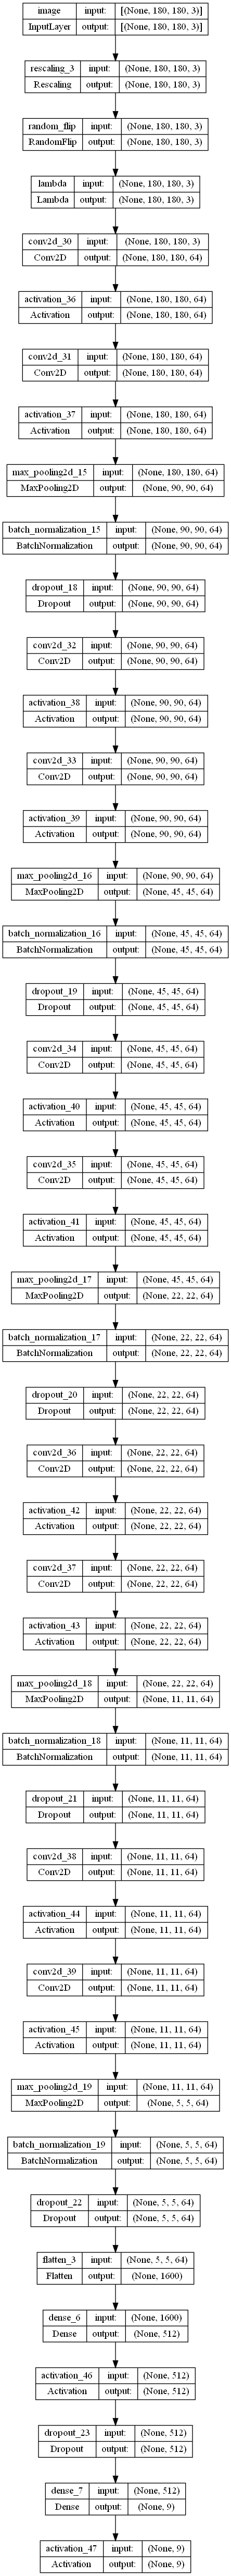

In [46]:
# Create and plot a diagram of the model
keras.utils.plot_model(model, "sequential_augmented_network.png", show_shapes=True)

### 3.4. Compile the model

In [47]:
# Compile the model
model.compile(loss=CategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

### 3.5. Train the model

In [48]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code

# Train the model for 20 epochs
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/50
56/56 [==============================] - 20s 319ms/step - loss: 3.0689 - accuracy: 0.2294 - val_loss: 2.5387 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 17s 312ms/step - loss: 2.5136 - accuracy: 0.2907 - val_loss: 2.3597 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 17s 313ms/step - loss: 2.0229 - accuracy: 0.3504 - val_loss: 2.4497 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - 17s 313ms/step - loss: 1.8009 - accuracy: 0.4074 - val_loss: 2.2726 - val_accuracy: 0.2438 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 17s 311ms/step - loss: 1.6605 - accuracy: 0.4208 - val_loss: 2.9817 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 6/50
56/56 [==============================] - 17s 312ms/step - loss: 1.5419 - accuracy: 0.4738 - val_loss: 2.4172 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 7/50
56/56 [==============================] - 17s 312ms/st

### 3.6. Visualize the training results

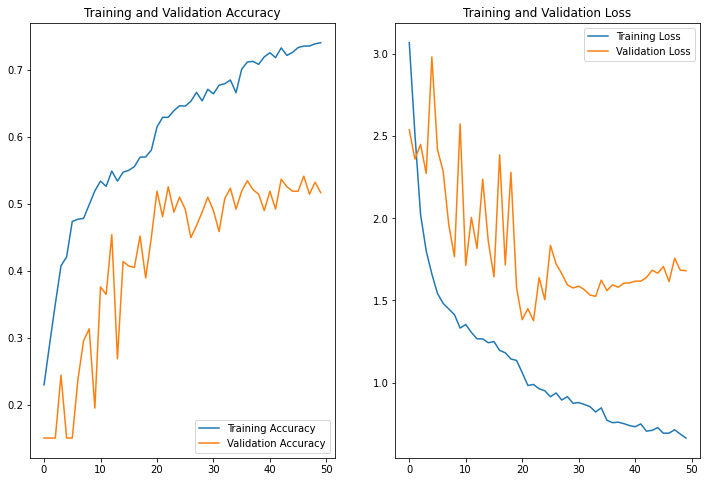

In [49]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3.7. Verify predictions against the test dataset

In [50]:
# Make predictions against the test dataset and compute the model accuracy
test_predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
  test_predictions = np.concatenate([test_predictions, np.argmax(model.predict(x), axis = -1)])
  test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

test_accuracy = np.sum(test_predictions == test_labels) / len(test_predictions)
print('Test accuracy:', test_accuracy)

1/1 [==============================] - 0s 286ms/step
Test accuracy: 0.3559322033898305


### 3.8. Discussion and findings

Rotating and flipping the training images should make the model more robust. However, the model accuracy (when verified against the validation dataset) appears to only sligtly better compared to the previous model. And as with the previous model, the this model also appears to be overfitting the training data after approximately 25 epochs of training.

# 4. Investigate class imbalance

### 4.1. Plot the class distribution of the training dataset

In [51]:
# Find the number of samples in the training dataset
len(list(train_ds.unbatch()))

1792

In [52]:
# Find the number of samples per class in the training dataset
labels = []
for (image, label) in tuple(train_ds.unbatch()):
    labels.append(label.numpy())

df_train_counts = pd.DataFrame(labels)
df_train_counts.columns = class_names
train_value_counts = df_train_counts.sum().astype(int)
train_value_counts

actinic keratosis              92
basal cell carcinoma          309
dermatofibroma                 77
melanoma                      352
nevus                         277
pigmented benign keratosis    370
seborrheic keratosis           58
squamous cell carcinoma       142
vascular lesion               115
dtype: int32

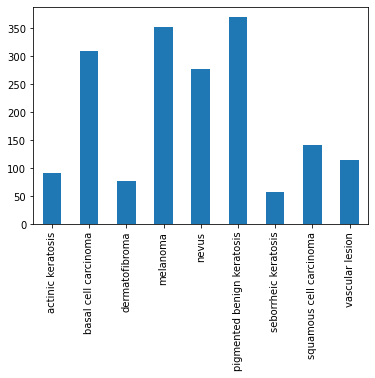

In [53]:
# Plot the number of samples per class in the training dataset
figure = plt.figure()
figure.set_figwidth(6)
figure.set_figheight(4)
train_value_counts.plot.bar()
plt.show()

### 4.2. Plot the class distribution of the validation dataset

In [54]:
# Find the number of samples per class in the validation dataset
labels = []
for (image, label) in tuple(val_ds.unbatch()):
    labels.append(label.numpy())

df_val_counts = pd.DataFrame(labels)
df_val_counts.columns = class_names
val_value_counts = df_val_counts.sum().astype(int)
val_value_counts

actinic keratosis             22
basal cell carcinoma          67
dermatofibroma                18
melanoma                      86
nevus                         80
pigmented benign keratosis    92
seborrheic keratosis          19
squamous cell carcinoma       39
vascular lesion               24
dtype: int32

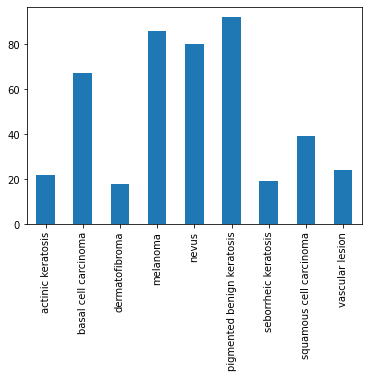

In [55]:
# Plot the number of samples per class in the validation dataset
figure = plt.figure()
figure.set_figwidth(6)
figure.set_figheight(4)
val_value_counts.plot.bar()
plt.show()

### 4.3. Find the class distribution of the training and validation datasets combined

In [56]:
# Find the number of samples per class in the training and validation datasets combined
df_combined_counts = train_value_counts + val_value_counts
df_combined_counts

actinic keratosis             114
basal cell carcinoma          376
dermatofibroma                 95
melanoma                      438
nevus                         357
pigmented benign keratosis    462
seborrheic keratosis           77
squamous cell carcinoma       181
vascular lesion               139
dtype: int32

### 4.4. Discussion and findings

The seborrheic keratosis class has the fewest number of elements, with 77 samples in the training dataset. In contrast, the pigmented benign keratosis class has 462 samples. The melanoma, basal cell carcinoma, and nevus classes are also overrepresented in the training dataset.

The ratio between the number of samples of the least and most represented classes is of six times. There is thus a significant class imbalance in the dataset.

# 5. Rectify the class imbalance

### 5.1. Split the training and validation datasets using stratified sampling

In [61]:
# Find the augmentation image files
training_dirs = glob(os.path.join(data_dir_train, '*'))

In [66]:
# Use 80% for training and 20% for validation
train_validation_split = 0.8

# Find the base directory
image_base_dir = os.path.dirname(data_dir_train)
print('Base image directory:', image_base_dir)

# Create a subdirectory for the training dataset
sampled_train_dir = image_base_dir + '\\sampled_train'
if not os.path.exists(sampled_train_dir):
    os.makedirs(sampled_train_dir)
print('Output training data directory:', sampled_train_dir)

# Create a subdirectory for the validation dataset
sampled_val_dir = image_base_dir + '\\sampled_validation'
if not os.path.exists(sampled_val_dir):
    os.makedirs(sampled_val_dir)
print('Output validation data directory:', sampled_val_dir)

# Iterate over the classes
for training_dir in training_dirs:
    base_dir_name = os.path.basename(training_dir)
    print('Sampling from class:', base_dir_name)
    
    # Create a class subdirectory for the training dataset
    sampled_train_class_dir = sampled_train_dir + '\\' + base_dir_name
    if not os.path.exists(sampled_train_class_dir):
        os.makedirs(sampled_train_class_dir)
    
    # Create a class subdirectory for the validation dataset
    sampled_val_class_dir = sampled_val_dir + '\\' + base_dir_name
    if not os.path.exists(sampled_val_class_dir):
        os.makedirs(sampled_val_class_dir)
    
    # Find the number of files per class
    files_in_class = glob(os.path.join(training_dir, '*'))
    number_files_in_class = len(files_in_class)
    print('Number of samples:', number_files_in_class)
    
    # Iterate over the files in the class
    i = 1;
    for file_in_class in files_in_class:
        # Find the filename
        full_path, filename = os.path.split(file_in_class)
        
        # Stratified sampling
        if i < train_validation_split * number_files_in_class:
            copy_filename = sampled_train_class_dir + '\\' + filename;
            shutil.copyfile(file_in_class, copy_filename)
        else:
            copy_filename = sampled_val_class_dir + '\\' + filename;
            shutil.copyfile(file_in_class, copy_filename)
        i += 1;

Base image directory: C:\development\data\ISIC
Output training data directory: C:\development\data\ISIC\sampled_train
Output validation data directory: C:\development\data\ISIC\sampled_validation
Sampling from class: actinic keratosis
Number of samples: 114
Sampling from class: basal cell carcinoma
Number of samples: 376
Sampling from class: dermatofibroma
Number of samples: 95
Sampling from class: melanoma
Number of samples: 438
Sampling from class: nevus
Number of samples: 357
Sampling from class: pigmented benign keratosis
Number of samples: 462
Sampling from class: seborrheic keratosis
Number of samples: 77
Sampling from class: squamous cell carcinoma
Number of samples: 181
Sampling from class: vascular lesion
Number of samples: 139


### 5.2. Augment the training dataset

In [67]:
# Defining the path for sampled training images
sampled_train_path = pathlib.Path(sampled_train_dir)

In [68]:
## Add 500 samples per class to make sure that none of the classes are sparse
for i in class_names:
    folder_path = sampled_train_path.joinpath(i)
    pipeline = Augmentor.Pipeline(folder_path)
    pipeline.rotate(probability=1, max_left_rotation=15, max_right_rotation=15)
    pipeline.rotate_random_90(probability=0.75)
    pipeline.flip_left_right(probability=0.5)
    pipeline.flip_top_bottom(probability=0.5)
    pipeline.sample(500)

Initialised with 91 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=450x600 at 0x1C9D7BCC280>: 100%|██████████| 500/500 [00:03<00:00, 145.05 Samples/s]


Initialised with 300 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=450x600 at 0x1CA41339A60>: 100%|██████████| 500/500 [00:03<00:00, 146.54 Samples/s]


Initialised with 75 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=450x600 at 0x1C9D794FAC0>: 100%|██████████| 500/500 [00:03<00:00, 144.05 Samples/s]


Initialised with 350 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CA532629A0>: 100%|██████████| 500/500 [00:22<00:00, 22.07 Samples/s] 


Initialised with 285 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x1C9D1E740D0>: 100%|██████████| 500/500 [00:21<00:00, 23.23 Samples/s]


Initialised with 369 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CA23B075E0>: 100%|██████████| 500/500 [00:03<00:00, 142.73 Samples/s]


Initialised with 61 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C9D1F542E0>: 100%|██████████| 500/500 [00:08<00:00, 56.74 Samples/s]


Initialised with 144 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C9D7E4F460>: 100%|██████████| 500/500 [00:03<00:00, 140.67 Samples/s]


Initialised with 111 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=450x600 at 0x1C9D7926E20>: 100%|██████████| 500/500 [00:03<00:00, 139.94 Samples/s]


In [70]:
# Find the total count of augmented validation images
image_count_train = len(list(sampled_train_path.glob('*/output/*.jpg')))
print(image_count_train)

4500


### 5.3. Augment the validation dataset

In [71]:
# Defining the path for sampled validation images
sampled_val_path = pathlib.Path(sampled_val_dir)

In [72]:
## Add 120 samples per class to make sure that none of the classes are sparse
for i in class_names:
    folder_path = sampled_val_path.joinpath(i)
    pipeline = Augmentor.Pipeline(folder_path)
    pipeline.rotate(probability=1, max_left_rotation=15, max_right_rotation=15)
    pipeline.rotate_random_90(probability=0.75)
    pipeline.flip_left_right(probability=0.5)
    pipeline.flip_top_bottom(probability=0.5)
    pipeline.sample(120)

Initialised with 23 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_validation\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CA4CFB0790>: 100%|██████████| 120/120 [00:00<00:00, 148.51 Samples/s]


Initialised with 76 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_validation\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=450x600 at 0x1C9D7DAC880>: 100%|██████████| 120/120 [00:00<00:00, 150.75 Samples/s]


Initialised with 20 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_validation\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=450x600 at 0x1C9D78CFEB0>: 100%|██████████| 120/120 [00:00<00:00, 142.86 Samples/s]


Initialised with 88 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_validation\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=768x1024 at 0x1C9D1F5AB50>: 100%|██████████| 120/120 [00:02<00:00, 58.20 Samples/s]


Initialised with 72 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_validation\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=450x600 at 0x1C9D7ACC280>: 100%|██████████| 120/120 [00:00<00:00, 133.93 Samples/s]


Initialised with 93 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_validation\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C9D7ACC7C0>: 100%|██████████| 120/120 [00:00<00:00, 138.25 Samples/s]


Initialised with 16 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_validation\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=768x1024 at 0x1C9D7CEDC10>: 100%|██████████| 120/120 [00:02<00:00, 56.23 Samples/s]


Initialised with 37 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_validation\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=450x600 at 0x1C9D7ACCD90>: 100%|██████████| 120/120 [00:00<00:00, 142.86 Samples/s]


Initialised with 28 image(s) found.
Output directory set to C:\development\data\ISIC\sampled_validation\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C9D7CB09A0>: 100%|██████████| 120/120 [00:00<00:00, 135.36 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.

In [74]:
# Find the total count of augmented validation images
image_count_val = len(list(sampled_val_path.glob('*/output/*.jpg')))
print(image_count_val)

1080


### 5.2. Validate the distribution of augmented data

Find the distribution of augmented data after adding new images to the original training data.

In [75]:
# Find the augmentation image files
path_list_new = [x for x in glob(os.path.join(sampled_train_dir, '*', 'output', '*.jpg'))]
path_list_new

['C:\\development\\data\\ISIC\\sampled_train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4554e403-6f7a-4f6f-a49a-e5e5d0319a25.jpg',
 'C:\\development\\data\\ISIC\\sampled_train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_876770ee-01e9-4f33-9c2d-0d83538cad62.jpg',
 'C:\\development\\data\\ISIC\\sampled_train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b097bfa7-d76d-43d9-9234-cadfd5021afd.jpg',
 'C:\\development\\data\\ISIC\\sampled_train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_fe9dbf35-c4d9-4dbb-b5fd-2f4f99f34893.jpg',
 'C:\\development\\data\\ISIC\\sampled_train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_49aac38c-6d3e-461e-9241-7951c37250f0.jpg',
 'C:\\development\\data\\ISIC\\sampled_train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_53c69ffc-a15c-4bbf-b46a-5a87e6a042d2.jpg',
 'C:\\development\\data\\ISIC\\sampled_t

In [77]:
# Find the classes
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(sampled_train_dir, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [81]:
# Match the files with the classes
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [82]:
# Find the number of samples per class in the training dataset after augmentation
df2['Label'].value_counts() + train_value_counts

actinic keratosis             592
basal cell carcinoma          809
dermatofibroma                577
melanoma                      852
nevus                         777
pigmented benign keratosis    870
seborrheic keratosis          558
squamous cell carcinoma       642
vascular lesion               615
dtype: int64

The classes are much more balanced after adding 500 images to every class.

# 6. Sequential network with augmented training data

### 6.1. Configure the loader

Configure the loader to load the training and validation image datasets that were augmented with additional images.

In [83]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=sampled_train_path,
    seed=123,
    color_mode='rgb',
    interpolation='lanczos3',
    shuffle=True,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6286 files belonging to 9 classes.


In [84]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=sampled_val_path,
    seed=123,
    color_mode='rgb',
    interpolation='lanczos3',
    shuffle=True,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1533 files belonging to 9 classes.


### 6.2. Create the model

Create the same sequential model as was used previously.

In [85]:
# Instantiate a sequential model
model = Sequential()

# Add an input layer
model.add(Input(shape=(img_height, img_width, 3), name="image"))

# Add an rescaling layer to convert the pixel value ranges from 0-255 to 0-1
model.add(Rescaling(1.0/255.0, input_shape=(img_height, img_width, 3)))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with two 3x3 convolution layers using ReLU activation
# Follow with max pooling, batch normalization, and dropout layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a block with a flattening layer using ReLU activation
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(9))
model.add(Activation('softmax'))

### 6.3. Compile the model

In [86]:
# Compile the model
model.compile(loss='categorical-crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 6.4. Train the model

In [87]:
# Train the model for 50 epochs while reducing the learning rate over time
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/50
197/197 [==============================] - 56s 273ms/step - loss: 2.5026 - accuracy: 0.2351 - val_loss: 2.3728 - val_accuracy: 0.1409 - lr: 0.0010
Epoch 2/50
197/197 [==============================] - 50s 254ms/step - loss: 1.6437 - accuracy: 0.3718 - val_loss: 2.4216 - val_accuracy: 0.2387 - lr: 0.0010
Epoch 3/50
197/197 [==============================] - 50s 254ms/step - loss: 1.4882 - accuracy: 0.4181 - val_loss: 2.9210 - val_accuracy: 0.2838 - lr: 0.0010
Epoch 4/50
197/197 [==============================] - 50s 254ms/step - loss: 1.4178 - accuracy: 0.4520 - val_loss: 2.2510 - val_accuracy: 0.3079 - lr: 0.0010
Epoch 5/50
197/197 [==============================] - 50s 253ms/step - loss: 1.3740 - accuracy: 0.4653 - val_loss: 2.0426 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 6/50
197/197 [==============================] - 50s 254ms/step - loss: 1.3554 - accuracy: 0.4645 - val_loss: 2.4256 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 7/50
197/197 [==============================] 

### 6.5. Visualize the training results

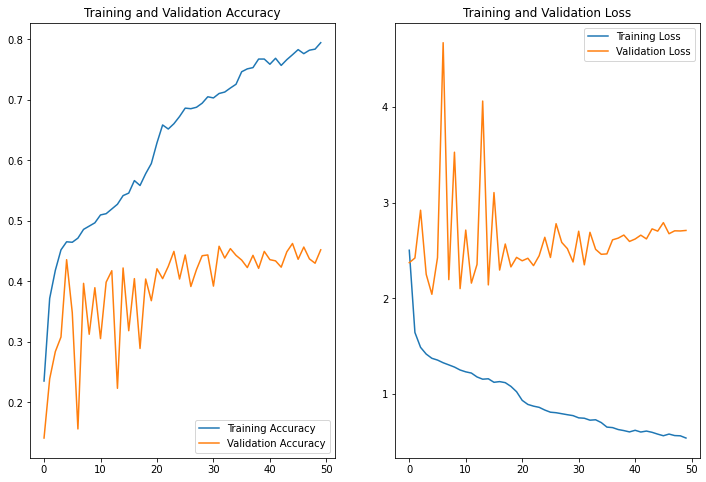

In [88]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6.6. Verify predictions against the test dataset

In [89]:
# Make predictions against the test dataset and compute the model accuracy
test_predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
  test_predictions = np.concatenate([test_predictions, np.argmax(model.predict(x), axis = -1)])
  test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

test_accuracy = np.sum(test_predictions == test_labels) / len(test_predictions)
print('Test accuracy:', test_accuracy)

1/1 [==============================] - 0s 195ms/step
Test accuracy: 0.4745762711864407


### 6.7. Discussion and findings

The accuracy against the test dataset improved to 47.4%. The improvement can attributed to the reduction of the class imbalance through the augmentation of the training dataset.

However, this model still appears to be overfitting the training data, with the validation accuracy diverging from the training accuracy after approximately 25 epochs.

# 7. Residual network with data augmentation

More layers are needed to extract more information, but adding more layers may lead to vanishing gradients and washout. To avoid this, we add bypass connections between processing blocks and lower layers. This model is based on the ResNet architecture. But due to the limited amount of training data and computational resources available, this model has far fewer layers than the ResNet models.

### 7.1. Create the model

In [121]:
# Input layer
inputs = keras.Input(shape=(img_height, img_width, 3), name="image")

# Rescaling
x = tf.keras.layers.Rescaling(1.0/255.0, input_shape=(180, 180, 3))(inputs)

# First convolution block
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

# Repeated blocks with bypass connections
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_3_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_4_output = layers.add([x, block_3_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_4_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_5_output = layers.add([x, block_4_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_5_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_6_output = layers.add([x, block_5_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_6_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_7_output = layers.add([x, block_6_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_7_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_8_output = layers.add([x, block_7_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_8_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_9_output = layers.add([x, block_8_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_9_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_10_output = layers.add([x, block_9_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_10_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_11_output = layers.add([x, block_10_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_11_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
block_12_output = layers.add([x, block_11_output])

# Output layer
x = layers.Conv2D(64, 3, activation="relu")(block_8_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(class_names), 'softmax')(x)

model = keras.Model(inputs, outputs, name="model")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 180, 180, 3)  0           ['image[0][0]']                  
                                                                                                  
 conv2d_149 (Conv2D)            (None, 178, 178, 64  1792        ['rescaling_11[0][0]']           
                                )                                                                 
                                                                                              

 add_55 (Add)                   (None, 59, 59, 64)   0           ['batch_normalization_80[0][0]', 
                                                                  'add_54[0][0]']                 
                                                                                                  
 conv2d_162 (Conv2D)            (None, 59, 59, 64)   36928       ['add_55[0][0]']                 
                                                                                                  
 conv2d_163 (Conv2D)            (None, 59, 59, 64)   36928       ['conv2d_162[0][0]']             
                                                                                                  
 dropout_92 (Dropout)           (None, 59, 59, 64)   0           ['conv2d_163[0][0]']             
                                                                                                  
 batch_normalization_81 (BatchN  (None, 59, 59, 64)  256         ['dropout_92[0][0]']             
 ormalizat

In [122]:
# View the summary of all layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 180, 180, 3)  0           ['image[0][0]']                  
                                                                                                  
 conv2d_149 (Conv2D)            (None, 178, 178, 64  1792        ['rescaling_11[0][0]']           
                                )                                                                 
                                                                                              

 add_55 (Add)                   (None, 59, 59, 64)   0           ['batch_normalization_80[0][0]', 
                                                                  'add_54[0][0]']                 
                                                                                                  
 conv2d_162 (Conv2D)            (None, 59, 59, 64)   36928       ['add_55[0][0]']                 
                                                                                                  
 conv2d_163 (Conv2D)            (None, 59, 59, 64)   36928       ['conv2d_162[0][0]']             
                                                                                                  
 dropout_92 (Dropout)           (None, 59, 59, 64)   0           ['conv2d_163[0][0]']             
                                                                                                  
 batch_normalization_81 (BatchN  (None, 59, 59, 64)  256         ['dropout_92[0][0]']             
 ormalizat

### 7.2. Visualize the model

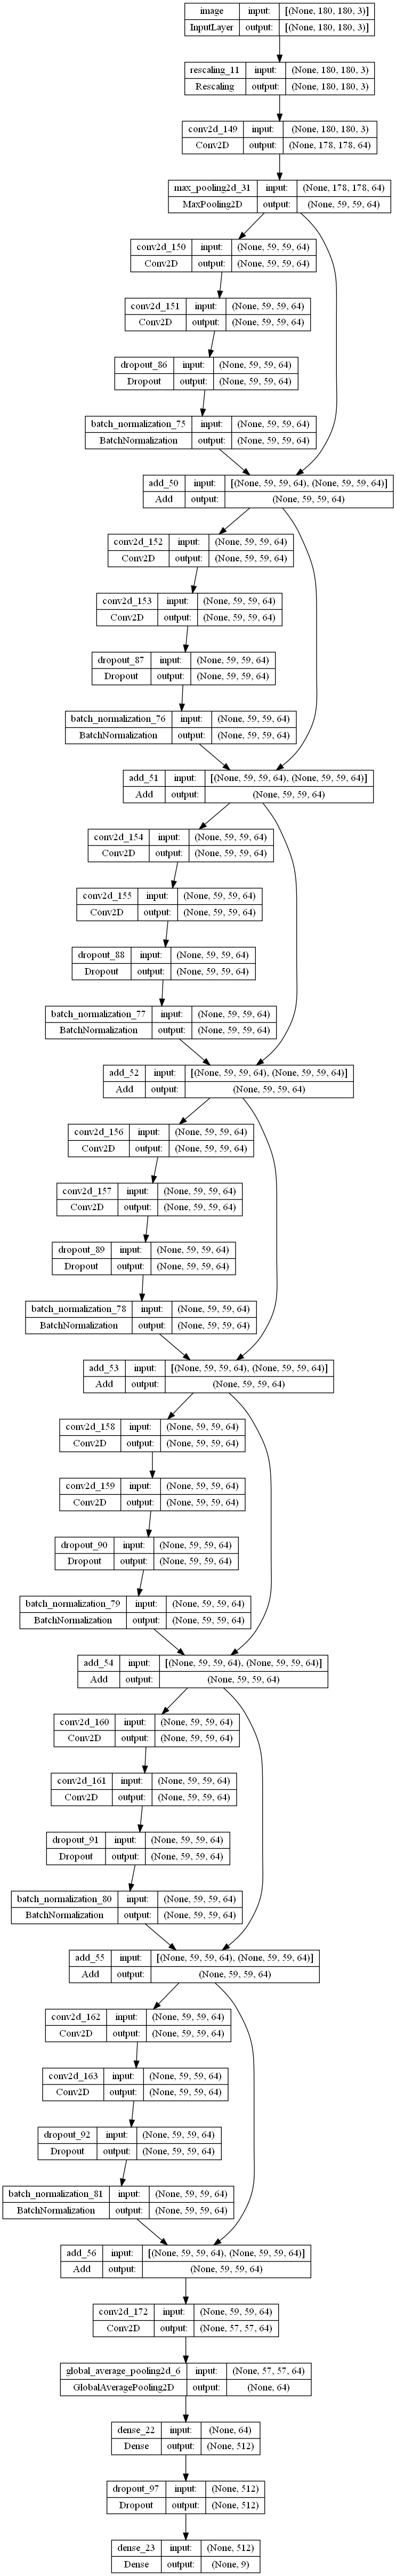

In [123]:
# Create and plot a diagram of the model
keras.utils.plot_model(model, "residual_network.png", show_shapes=True)

### 7.3. Compile the model

In [124]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 7.4. Train the model

In [125]:
# Train the model for 50 epochs
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/50
197/197 [==============================] - 58s 283ms/step - loss: 1.6717 - accuracy: 0.3482 - val_loss: 2.6003 - val_accuracy: 0.1337 - lr: 0.0010
Epoch 2/50
197/197 [==============================] - 57s 286ms/step - loss: 1.4618 - accuracy: 0.4244 - val_loss: 18.6176 - val_accuracy: 0.1357 - lr: 0.0010
Epoch 3/50
197/197 [==============================] - 57s 287ms/step - loss: 1.3957 - accuracy: 0.4500 - val_loss: 2.4262 - val_accuracy: 0.2237 - lr: 0.0010
Epoch 4/50
197/197 [==============================] - 58s 293ms/step - loss: 1.3408 - accuracy: 0.4744 - val_loss: 3.7268 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 5/50
197/197 [==============================] - 59s 299ms/step - loss: 1.3125 - accuracy: 0.4871 - val_loss: 5.6455 - val_accuracy: 0.2309 - lr: 0.0010
Epoch 6/50
197/197 [==============================] - 56s 282ms/step - loss: 1.2689 - accuracy: 0.4967 - val_loss: 3.0447 - val_accuracy: 0.2622 - lr: 0.0010
Epoch 7/50
197/197 [==============================]

### 7.5. Visualize the training results

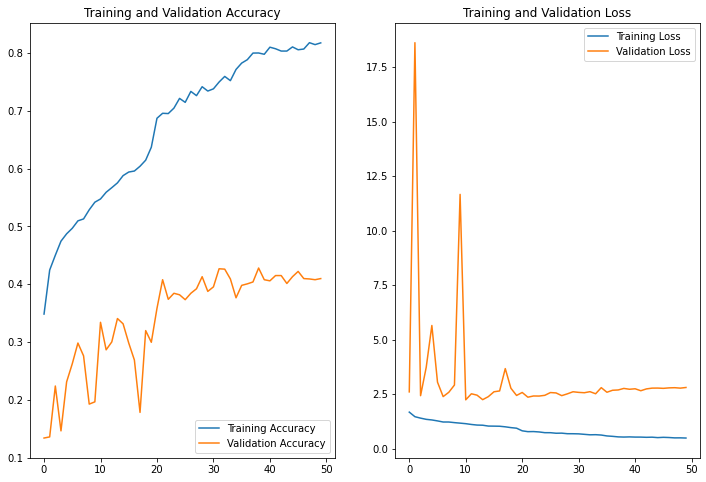

In [126]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 7.6. Check predictions against the test dataset

In [127]:
# Make predictions against the test dataset and compute the model accuracy
test_predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    test_predictions = np.concatenate([test_predictions, np.argmax(model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

test_accuracy = np.sum(test_predictions == test_labels) / len(test_predictions)
print('Test accuracy:', test_accuracy)

1/1 [==============================] - 0s 268ms/step
Test accuracy: 0.423728813559322


### 7.7. Discussion and findings

The sequential model outperformed the more complex and deeper residual network.  This can be attributed to the limited size of the training dataset which was likely insufficient to adequatly train the more complex network. Higher accuracy might be achievable when using transfer learning with a pretrained residual network.